# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

The goals of this project are the following:

<ul>
<li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
<li>Apply a distortion correction to raw images.
<li>Use color transforms, gradients, etc., to create a thresholded binary image.
<li>Apply a perspective transform to rectify binary image (birds-eye view).
<li>Detect lane pixels and fit to find the lane boundary.
<li>Determine the curvature of the lane and vehicle position with respect to center.
<li>Warp the detected lane boundaries back onto the original image.
<li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
</ul>

---

## Import Packages

In [1]:
### Importing necessary packages

import numpy as np                  # For handling images
import glob                         # For iterating through multiple image files
import cv2                          # For image manipulation
import matplotlib.pyplot as plt     # For plotting images

# For plotting to display inline within the notebook
%matplotlib inline

print("All package import complete")

All package import complete


## Define Global Variables

In [2]:
### Global variables and constants defined here

detected_lines = []                  # Global variable to hold all detected lines
reset_lanes = True                   # Flag that drives detection of fresh lanes
terrain_type = None                  # Variable that indicates the terrain type
mtx = dist = None                    # Camera caliberation parameters
perspective_M = perspective_Minv = None  # Perspective and inverse perspective
baseline_lane_width = None           # Baseline lane width in px calculated from reference image
cb = np.empty([360,1930,3])          # Holding variable for image concatenation        
c1 = np.empty([360,640,3])           # Holding variable for image concatenation
c2 = np.empty([370,640,3])           # Holding variable for image concatenation

class Line():                        # Objects of this Line class hold details of a detected lines
    def __init__(self):

        self.fresh_lane = None
        self.good_lane = None
        self.continous_bad_lanes = 0
        self.leftx_base = None
        self.rightx_base = None
        self.leftx = None
        self.lefty = None
        self.rightx = None
        self.righty = None
        self.left_fit = None
        self.right_fit = None
        self.left_curverad = None
        self.right_curverad = None
        self.center_offset_m = None
        self.lane_width = None
        self.top_lane_width = None
        self.smooth_leftx = 0
        self.smooth_rightx = 0
        self.smooth_leftx_base = 0
        self.smooth_rightx_base = 0
        self.smooth_left_fit = [0,0,0]
        self.smooth_right_fit = [0,0,0]

print("All global variable definition complete")

All global variable definition complete


## Define support functions

The helper functions needed for this project are defined in this section

In [3]:
### Support Functions

""" The helper functions needed to identify lanes are defined in this section """

def showImg(img):
    """ Combines plt.imshow() and plt.show() so that
        grayscale images can be displayed with a single line funtion call"""
    plt.imshow(img)
    plt.show()
    return

def showGrayImg(img):
    """ Combines plt.imshow() and plt.show() so that 
        images can be displayed with a single line funtion call"""
    plt.imshow(img, cmap="gray")
    plt.show()
    return

def undistort(img):
    """ Undistorts a given image using 
        Camera caliberations"""
    return cv2.undistort(img, mtx, dist, None, mtx)

def grayscale(img):
    """Applies the Grayscale transform
       This will return an image with only one color channel"""
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def check_lighting(img):
    """Checks for low luminosity (shadow or cloudy conditions)
       This will return "Good" if good lighting else return "Poor" """

    img = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    img_luminosity = img[430:,:,1]
    if np.average(img_luminosity) < 50:
        lighting_condition = "Poor"
        drive_log.write("@ " + str(len(detected_lines)) + " - Switched ON headlights " + 
                        str(np.average(img_luminosity)) + "\n")
    else:
        lighting_condition = "Good"
#    print(np.average(img_luminosity))
    
    return lighting_condition

def switch_on_headlights(img):
    """Illuminates lower half of the image by increasing luminosity
       Returns the input image with bottom section illuminated """
  
    illuminated_image = cv2.cvtColor(img,cv2.COLOR_RGB2HLS)
    illuminated_image = np.int16(illuminated_image)
    illuminated_image[430:,:,1] = np.clip(illuminated_image[430:,:,1] * 2, 0, 255)
#    illuminated_image[430:,:,2] = np.clip(illuminated_image[430:,:,2] * 1.5, 0, 255)
    illuminated_image = np.uint8(illuminated_image)
    illuminated_image = cv2.cvtColor(illuminated_image, cv2.COLOR_HLS2RGB)
    
    return illuminated_image

def gradient(gray, orient, sobel_kernel, thresh):
    """ Calculates directional gradient in the required orientation
        Applies threshold"""
    
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def gradient_mag(gray, sobel_kernel, mag_thresh):
    """ Calculates gradient magnitude
        Applies threshold"""

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.sqrt( (sobelx*sobelx) + (sobely*sobely) )
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def gradient_dir(gray, sobel_kernel, dir_thresh):
    """ Calculates gradient direction
        Applies threshold"""
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
#    scaled_dir_grad = np.uint8(255*dir_grad/np.max(dir_grad))
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= dir_thresh[0]) & (dir_grad <= dir_thresh[1])] = 1
    return dir_binary

def s_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_s = img[:,:,2]

    sbinary = np.zeros_like(img_s)
    sbinary[(img_s > thresh[0]) & (img_s <= thresh[1])] = 1
    return sbinary

def l_select(img, thresh):
    """ 1) Converts image to HLS color space
        2) Apply a threshold to the S channel
        3) Return a binary image of threshold result """
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    img_l = img[:,:,1]

    lbinary = np.zeros_like(img_l)
    lbinary[(img_l > thresh[0]) & (img_l <= thresh[1])] = 1
    return lbinary

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    global terrain_type
    
    if terrain_type == 'h':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 360
#        mask_top_right_x = 680
        mask_top_right_x = 800
        mask_bottom_right_x = 1190
#        mask_bottom_right_x = 1240
        mask_bottom_left_x = 75
    elif terrain_type == 'c':
        mask_top_y = 470
        mask_bottom_y = 720
        mask_top_left_x = 580
        mask_top_right_x = 750
#        mask_bottom_right_x = 1150
        mask_bottom_right_x = 1125
        mask_bottom_left_x = 180
    else:
        mask_top_y = 440
        mask_bottom_y = 720
        mask_top_left_x = 530
        mask_top_right_x = 740
        mask_bottom_right_x = 1165
        mask_bottom_left_x = 150
        
    
    vertices = np.array([[(mask_top_left_x, mask_top_y), (mask_top_right_x, mask_top_y),  \
                          (mask_bottom_right_x, mask_bottom_y), (mask_bottom_left_x, mask_bottom_y)]],  \
                             dtype=np.int32) # vertices of the masked area

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

def calculate_curvature(y_eval, fit):
    """Calculates the radius of curvature of a given line"""
    # y_eval : y-value where we want radius of curvature
    # fit : left or right line fit
    return ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    return lines

def img_collage(marked_img):
    """ Concatenate images into a single image
        This helps view different perspectives of the image
        at the same time helping with debugging"""
    global c1, c2
    c3 = np.concatenate((c1,c2),0)    
    marked_img = cv2.resize(marked_img,(1280, 720))
    c0 = cv2.copyMakeBorder(marked_img,0,10,0,10,cv2.BORDER_CONSTANT, value=[255,255,0])
    ct = np.concatenate((c0,c3),1)
    c = np.concatenate((ct,cb),0)
    c = cv2.resize(c,(1280, 720))
    return c

## Extract warped binary image of the lanes

This function takes in a 3 channel RGB color image and returns a warped binary image with the lane markings only

In [4]:
### Function to extract a warped binary image of the lanes

""" This function takes in a 3 channel RGB olor image and 
    returns a warped binary image with the lane markings only """

    # Undistort the image
    # Create necessary color channel filters
    # Create necessary sobel filters
    # Create a combined filter that provides the best results
    # Apply mask to pick up lane pixels only
    # Warp the image

def get_binary_warp(image):

    # Undistort the camera image
    image = undistort(image)
    
    lighting_condition = check_lighting(image)
    if lighting_condition == "Poor":
        image = switch_on_headlights(image)

    # Get image filtered by S channel
    s_chn_img = s_select(image, thresh=(100,255))
    
    # Get image filtered by L channel
    l_chn_img = l_select(image, thresh=(50,255))
    
    
    # Grayscale the image.  Filter out low intensity pixels to remove black patches / lines from image.
    gimg = grayscale(image)
    gray_img = grayscale(image)
    gray_img[gray_img < 200] = 0

    
    # Get image filtered by sobel x
    sobelx_img = gradient(gray_img, orient='x', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel y
    sobely_img = gradient(gray_img, orient='y', sobel_kernel=9, thresh=(20,100))
    
    # Get image filtered by sobel magnitude
#    sobel_mag = gradient_mag(gray_img, sobel_kernel=3, mag_thresh=(20,100))
    
    # Get image filtered by sobel gradient direction
#    sobel_dir = gradient_dir(gray_img, sobel_kernel=31, dir_thresh=(0.7,1.3))
    
    # Pick up pixels that have high S and L channel values.  This will help address shadow conditions
    combined_img1 = np.zeros_like(sobelx_img)
    combined_img1[((s_chn_img == 1) & (l_chn_img == 1))] = 1
    
    # Pick up pixels that have high sobel x and y values.  This will help pick only strong pixels.
    combined_img2 = np.zeros_like(sobelx_img)
    combined_img2[((sobelx_img == 1) & (sobely_img ==1))] = 1

    # Combine the two binary images.  This image :
    # 1. Will capture lanes under shadows as well
    # 2. Will pick up only strong pixels that have high values both in x and y
    combined_img = np.zeros_like(sobelx_img)
    combined_img[((combined_img1 == 1) | (combined_img2 ==1))] = 1
    

    # Apply mask for lane region only to filter out non-lane pixels.
    masked_image = region_of_interest(combined_img) 
    
    # Warp the image to provide a top down perspective view
    warped_image = cv2.warpPerspective(masked_image, perspective_M, gray_img.shape[::-1], flags=cv2.INTER_LINEAR)
#    showGrayImg(warped_image)

    """
    # Plot the images for review
    f = plt.figure(figsize=(60, 33))
    ax1 = plt.subplot(3, 4, 1)
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2 = plt.subplot(3, 4, 2)
    ax2.imshow(s_chn_img, cmap='gray')
    ax2.set_title('S Channel', fontsize=30)
    ax3 = plt.subplot(3, 4, 3)
    ax3.imshow(l_chn_img, cmap='gray')
    ax3.set_title('L Channel', fontsize=30)
    ax4 = plt.subplot(3, 4, 4)
    ax4.imshow(combined_img1, cmap="gray")
    ax4.set_title('S & L combined Img1', fontsize=30)
    ax5 = plt.subplot(3, 4, 5)
    ax5.imshow(gimg, cmap="gray")
    ax5.set_title('Gray Img', fontsize=30)
    ax6 = plt.subplot(3, 4, 6)
    ax6.imshow(gray_img, cmap="gray")
    ax6.set_title('Filtered Gray Image', fontsize=30)
    ax7 = plt.subplot(3, 4, 7)
    ax7.imshow(sobelx_img, cmap="gray")
    ax7.set_title('Gradient x', fontsize=30)
    ax8 = plt.subplot(3, 4, 8)
    ax8.imshow(sobely_img, cmap="gray")
    ax8.set_title('Gradient y', fontsize=30)
    ax9 = plt.subplot(3, 4, 9)
    ax9.imshow(combined_img2, cmap="gray")
    ax9.set_title('x & y Gradient combined Img2', fontsize=30)
    ax10 = plt.subplot(3, 4, 10)
    ax10.imshow(combined_img, cmap="gray")
    ax10.set_title('Combined1 + Combined 2 = Combined Img', fontsize=30)
    ax11 = plt.subplot(3, 4, 11)
    ax11.imshow(masked_image, cmap="gray")
    ax11.set_title('Masked View', fontsize=30)
    ax12 = plt.subplot(3, 4, 12)
    ax12.imshow(warped_image, cmap="gray")
    ax12.set_title('Warped Image', fontsize=30)
#    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    f.savefig('BinaryThreshold.png')
    plt.show()
    """
    
    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    c4 = cv2.resize(combined_img,(640, 360))
    c4 = np.dstack((c4, c4, c4))*255
    c4 = cv2.copyMakeBorder(c4,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c4,"Filtered Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    if lighting_condition == "Poor":
        cv2.putText(c4,"Head Lights ON", (200,330), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,0))
    else:
        cv2.putText(c4,"Head Lights OFF", (200,330), cv2.FONT_HERSHEY_PLAIN, 2, (100,100,100))
#    print("c4 shape = ", c4.shape)
    c5 = cv2.resize(masked_image,(640, 360))
    c5 = np.dstack((c5, c5, c5))*255
    c5 = cv2.copyMakeBorder(c5,0,0,0,5,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c5,"Masked Binary Image", (150,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c5 shape = ", c5.shape)
    c6 = cv2.resize(warped_image,(640, 360))
    c6 = np.dstack((c6, c6, c6))*255
#    c6 = cv2.copyMakeBorder(c6,0,0,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
    cv2.putText(c6,"Warped", (180,30), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
    cv2.putText(c6,"Image", (180,60), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255))
#    print("c6 shape = ", c6.shape)
    global cb
    cb = np.concatenate((c4, c5, c6),1)

    return warped_image

## Detect fresh left and right lanes a warped binary image

This function takes in a warped binary image of the lanes and detects the lanes.  This function is used during the start of the pipeline and whenever multiple bad lines are detected continously

In [5]:
### This function will locate a fresh set of lane lines from a given binary warped image
"""  This function called 
     1. During the start of the pipeline to find the lanes
     2. Whenever continous bad lanes are detected - this will help as a reset"""

def find_fresh_lanes(binary_warped):
    
#    print("Inside reset")
    drive_log.write("@ " + str(len(detected_lines)) + " - Inside reset\n")
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
#    plt.plot(histogram)
#    plt.show()
    

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
#    print(leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 20
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    bad_left_box = 0
    bad_right_box = 0
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        
        # Identify the nonzero pixels in x and y within the window
        if bad_left_box < 3:
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            left_lane_inds.append(good_left_inds)
            if len(good_left_inds) == 0:
                bad_left_box += 1

        if bad_right_box < 3:
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            right_lane_inds.append(good_right_inds)
            if len(good_right_inds) == 0:
                bad_right_box += 1

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Combine images to create a collage of different perspectives
    # This makes it easy to debug as many perspective are shown at the same time
    global c2
    c2 = cv2.resize(out_img,(640, 360))
    c2 = cv2.copyMakeBorder(c2,0,10,0,0,cv2.BORDER_CONSTANT, value=[255,255,0])
#    showImg(c2)
 
    # Reset the flag to indicate that fresh detection has been done
    global reset_lanes
    reset_lanes = False
    
#    showImg(out_img)

    return leftx_base, rightx_base, left_lane_inds, right_lane_inds
    

## Perform sanity check on lane lines

This function performs sanity checks on the identified lane lines and decides if they are high confidence detections

In [6]:
### Perform sanity checks.
""" 1. Sanity check the left and right lanes from the current detection.
    2. Sanity check the lanes against previous good values for continuity """

def sanity_check_lanes(l):
    
    good_lane = True
#    print("inside sanity")
    
    while True:

        # Low Pass Filter - Do the left and rigth lanes have enough pixels
        if len(l.leftx) < 10 or len(l.rightx) < 10:
            good_lane = False
#            print("@", len(detected_lines),  " > low pass failure : ", len(l.leftx), len(l.rightx) )
            drive_log.write("@ " + str(len(detected_lines)) + " > low pass failure : " 
                            + str(len(l.leftx)) + " " + str(len(l.rightx)) + "\n")
            break

        # Is the lane width at base reasonable (around 3.7 m)
        if not(3 < l.lane_width < 4.5):
            good_lane = False
#            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            drive_log.write("@ " + str(len(detected_lines)) + " > base lane width failure : " 
                            + str(l.lane_width) + "\n")
            break

        # Is the lane width at top reasonable (around 3.7 m)
        if not(3 < l.top_lane_width < 7):
            good_lane = False
#            print("@", len(detected_lines),  " > lane width failure : ", l.lane_width)
            drive_log.write("@ " + str(len(detected_lines)) + " > top lane width failure : " 
                            + str(l.top_lane_width) + "\n")
            break
        
        # Are the lane curvatures reasonable
        if l.left_curverad > 30000 or l.right_curverad > 30000:
            good_lane = False
#            print("@", len(detected_lines),  " > curve check failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > curve check failure : " 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break

        # Do the left and right lanes have similar curvature
        if abs(l.left_curverad - l.right_curverad) > 20000:
            good_lane = False
#            print("@", len(detected_lines),  " > left and right curves similarity failure : ", l.left_curverad, l.right_curverad)
            drive_log.write("@ " + str(len(detected_lines)) + " > left and right curves similarity failure :" 
                            + str(l.left_curverad) + " " + str(l.right_curverad) + "\n")
            break
            
        # Are the lanes parallel (co-eff check)
#        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0008:
        if abs(l.left_fit[0] - l.right_fit[0]) > 0.0025:
            good_lane = False
#            print("@", len(detected_lines),  " > 2nd order coefficient similarity failure : ", l.left_fit[0], l.right_fit[0])
            drive_log.write("@ " + str(len(detected_lines)) + " > 2nd order coefficient similarity failure :" 
                            + str(l.left_fit[0]) + " " + str(l.right_fit[0]) + "\n")
            break
            
        if abs(l.left_fit[1] - l.right_fit[1]) > 1.3:
            good_lane = False
#            print("@", len(detected_lines),  " > 1st order coefficient similarity failure : ", l.left_fit[1], l.right_fit[1])
            drive_log.write("@ " + str(len(detected_lines)) + " > 1st order coefficient similarity failure :" 
                            + str(l.left_fit[1]) + " " + str(l.right_fit[1]) + "\n")
            break
        
        if not l.fresh_lane:
            
            # Is the left lane position close to value from prev frame
                if abs(l.leftx_base - detected_lines[-1].leftx_base) > 100:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - left lane base offset high : ", 
#                          l.leftx_base, detected_lines[-1].leftx_base)
                    drive_log.write("@ " + str(len(detected_lines)) + " > Continuity check failed - left lane base offset high : " 
                                    + str(l.leftx_base) + " " + str(detected_lines[-1].leftx_base) + "\n")
                    break            

            # Is the right lane position close to value from prev frame
                if abs(l.rightx_base - detected_lines[-1].rightx_base) > 50:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - left lane base offset high : ", 
#                          l.leftx_base, detected_lines[-1].leftx_base)
                    drive_log.write("@ " + str(len(detected_lines)) + " > Continuity check failed - right lane base offset high : " 
                                    + str(l.rightx_base) + " " + str(detected_lines[-1].rightx_base) + "\n")
                    break    
        
            # Is the lane offset marginal from prev frame
                if abs(l.center_offset_m - detected_lines[-1].center_offset_m) > 0.5:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - lane offset variation high : ", 
#                          l.center_offset_m, detected_lines[-1].center_offset_m)
                    drive_log.write("@ " + str(len(detected_lines)) + " > Continuity check failed - lane offset variation high : " 
                                    + str(l.center_offset_m) + " " + str(detected_lines[-1].center_offset_m) + "\n")
                    break

            # Is the left curvature offset reasonable from prev frame
#                if abs(l.left_curverad - detected_lines[-1].left_curverad) > abs(3.0 * l.left_curverad):
                if 4.0 < (l.left_curverad / detected_lines[-1].left_curverad) < 0.25:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - left curve variation high : ", 
#                          l.left_curverad, detected_lines[-1].left_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - left curve variation high : " 
                                    + str(l.left_curverad) + " " + str(detected_lines[-1].left_curverad) + "\n")
                    break
            
            # Is the right curvature offset reasonable from prev frame
#                if abs(l.right_curverad - detected_lines[-1].right_curverad) > abs(3.0 * l.right_curverad):
                if 4.0 < (l.right_curverad / detected_lines[-1].right_curverad) < 0.25:
                    good_lane = False
#                    print("@", len(detected_lines),  " > Continuity check failed - right curve variation high : ", 
#                          l.right_curverad, detected_lines[-1].right_curverad)
                    drive_log.write("@ " + str(len(detected_lines)) + 
                                    " > Continuity check failed - right curve variation high : " 
                                    + str(l.right_curverad) + " " + str(detected_lines[-1].right_curverad) + "\n")
                    break

            # Is the co-eff offset reasonable from prev frame
            
        break
            
#    print("lane quality = ", good_lane)
    return good_lane

## Extract left and right lane fits from a warped binary image

This function takes in a warped binary image of the lanes and returns the left and right lane fits

In [7]:
### Function to extract the left and right line fits from a given warped binary image of the lanes

""" This function takes in a warped binary image of the lanes and 
    returns the left and right lane fits """

def get_line_fits(binary_warped):
    
#    print("inside get line fit")
    
#    showGrayImg(binary_warped)
    global reset_lanes
#    print('reset status', reset_lanes)

    # Identify indices of non-zero pixels from the binary image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create a new Line object to store the lane parameters
    l = Line()
    
    if reset_lanes :
        # Fresh lanes being built
        leftx_base, rightx_base, left_lane_inds, right_lane_inds = find_fresh_lanes(binary_warped)
        l.fresh_lane = True
    else:
        # Using coeff from last good detection for plotting new lanes
        l.fresh_lane = False
        margin = 100
        left_fit = detected_lines[-1].left_fit
        right_fit = detected_lines[-1].right_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        y_base = binary_warped.shape[0]
        leftx_base = left_fit[0]*(y_base**2) + left_fit[1]*y_base + left_fit[2]
        rightx_base = right_fit[0]*(y_base**2) + right_fit[1]*y_base + right_fit[2]

#        print(leftx_base, rightx_base)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 


    # Fit a second order polynomial to each lane
    if len(leftx) == 0 or len(lefty) == 0:
        leftx = detected_lines[-1].leftx
        lefty = detected_lines[-1].lefty
    if len(rightx) == 0 or len(righty) == 0:
        rightx = detected_lines[-1].rightx
        righty = detected_lines[-1].righty

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#    showImg(out_img)


    # Calculate radius of curvature
    global baseline_lane_width
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    y_eval = np.max(ploty) / 2  # y-value where we want radius of curvature
    ym_per_pix = 30/720 # meters per pixel in y dimension  -->  Manual observation
    xm_per_pix = 3.7/baseline_lane_width # meters per pixel in x dimension
#    xm_per_pix = 3.7/700 # meters per pixel in x dimension
#    ym_per_pix = 3/7 # meters per pixel in y dimension  -->  Manual observation


    # Calculate curvature in pixels
    left_curverad = calculate_curvature(y_eval, left_fit)
    right_curverad = calculate_curvature(y_eval, right_fit)
#    print("Curvature left = ", left_curverad, "px  right = ", right_curverad, "px")
    
    # Fit new polynomials to x,y in world space to calculate curvature in meters
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Determine lane width and offset
    lane_width = (rightx_base - leftx_base) * xm_per_pix
    leftx_top = left_fit[2]
    rightx_top = right_fit[2]
    top_lane_width = (rightx_top - leftx_top) * xm_per_pix
    lane_center = int(leftx_base + ((rightx_base - leftx_base) / 2))
    img_center = np.int(binary_warped.shape[1]/2)
    center_offset_px = img_center - lane_center
    center_offset_m = round((center_offset_px * xm_per_pix), 2)

    # Store detect lane parametes in the line object
    l.leftx_base = leftx_base
    l.rightx_base = rightx_base
    l.leftx = leftx
    l.lefty = lefty
    l.rightx = rightx
    l.righty = righty
    l.left_fit = left_fit
    l.right_fit = right_fit
    l.left_curverad = left_curverad
    l.right_curverad = right_curverad
    l.center_offset_m = center_offset_m
    l.lane_width = lane_width
    l.top_lane_width = top_lane_width
    l.smooth_leftx = leftx
    l.smooth_rightx = rightx
    l.smooth_left_fit = left_fit[:]
    l.smooth_right_fit = right_fit[:]

    # Sanity check the identified lanes.
    if len(detected_lines) == 0:
        # Handle first clip of the pipeline
#        print("inside first frame")
        l.good_lane = True
        l.continous_bad_lanes = 0
    else:
        l.continous_bad_lanes = detected_lines[-1].continous_bad_lanes
        l.good_lane = sanity_check_lanes(l)        

    # Create an image section that will show lane parameters
    # This makes it easy to debug
    global c1
    c1 = np.zeros_like(out_img)
    c1 = cv2.resize(c1,(640, 360))
    c1.fill(255)

    cv2.putText(c1,"Frame Metrics - " + str(len(detected_lines)), (200,30), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lx_base = " + str(int(leftx_base)), (10,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rx_base = " + str(int(rightx_base)), (10,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"bln_width= " + str(round(lane_width,2)), (10,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"tln_width= " + str(round(top_lane_width,2)), (10,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit2 = " + str(round(left_fit[2],2)), (10,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit2 = " + str(round(right_fit[2],2)), (10,210), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit1 = " + str(round(left_fit[1],3)), (10,240), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit1 = " + str(round(right_fit[1],3)), (10,270), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"lfit0 = " + str(round(left_fit[0],6)), (10,300), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"rfit0 = " + str(round(right_fit[0],6)), (10,330), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Fresh Lane = " + str(l.fresh_lane), (295,60), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Good Lane = " + str(l.good_lane), (285,90), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Bad Lns = " + str(l.continous_bad_lanes), (285,120), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Left Curve = " + str(int(l.left_curverad)), (285,150), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))
    cv2.putText(c1,"Right Curve = " + str(int(l.right_curverad)), (285,180), cv2.FONT_HERSHEY_PLAIN, 2, (0,0,255))

    # If the current lane detection is bad, use the previous good values to draw current lane
    if l.good_lane:
        l.continous_bad_lanes = 0
        i = 1
        # Smoothen the fit over the last n good detections
        for line in detected_lines[::-1]:
            l.smooth_leftx = l.smooth_leftx + l.leftx
            l.smooth_rightx = l.smooth_rightx + l.rightx
            l.smooth_left_fit = l.smooth_left_fit + line.left_fit
            l.smooth_right_fit = l.smooth_right_fit + line.right_fit
            i += 1
            if i >= 5:
                 break
        l.smooth_leftx = l.smooth_leftx / i
        l.smooth_rightx = l.smooth_rightx / i
        l.smooth_left_fit = (l.smooth_left_fit) / i
        l.smooth_right_fit = (l.smooth_right_fit) / i
    else:
        l.continous_bad_lanes += 1
        if l.continous_bad_lanes > 3: 
            global reset_lanes
            reset_lanes = True
        l.leftx_base = detected_lines[-1].leftx_base
        l.rightx_base = detected_lines[-1].rightx_base
        l.leftx = detected_lines[-1].leftx
        l.lefty = detected_lines[-1].lefty
        l.rightx = detected_lines[-1].rightx
        l.righty = detected_lines[-1].righty
        l.left_fit = detected_lines[-1].left_fit
        l.right_fit = detected_lines[-1].right_fit
        l.left_curverad = detected_lines[-1].left_curverad
        l.right_curverad = detected_lines[-1].right_curverad
        l.center_offset_m = detected_lines[-1].center_offset_m
        l.lane_width = detected_lines[-1].lane_width
        l.top_lane_width = detected_lines[-1].top_lane_width
        l.smooth_leftx = detected_lines[-1].leftx
        l.smooth_rightx = detected_lines[-1].rightx
        l.smooth_left_fit = detected_lines[-1].smooth_left_fit
        l.smooth_right_fit = detected_lines[-1].smooth_right_fit
    
    # Add the current lane lines to the detected_lines list
    detected_lines.append(l)

    return l

<ipython-input-7-1589ebe3a3a7>:172: SyntaxWarning: name 'reset_lanes' is used prior to global declaration
  global reset_lanes


## Lane Marker Pipeline

This function acts as a pipeline that takes a 3 channel RGB color image as input and returns the same image with lanes marked in it.


In [8]:
### Lane Marker Pipeline
""" This function acts as a pipeline that takes a 3 channel RGB color image as input
    and returns the same image with lanes marked in it """

def lane_marker_pipeline(image):

    # Get the binary warped image of the input image
    binary_warped = get_binary_warp(image)
    
    # Identify the left and right fits from the binary warped image
    l = get_line_fits(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = l.smooth_left_fit[0]*ploty**2 + l.smooth_left_fit[1]*ploty + l.smooth_left_fit[2]
    right_fitx = l.smooth_right_fit[0]*ploty**2 + l.smooth_right_fit[1]*ploty + l.smooth_right_fit[2]

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    line_width = 15
 
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - line_width, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + line_width, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - line_width, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + line_width, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,0, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 0.5, window_img, 1.0, 0)

    
    """
    # Draw images
    f = plt.figure(figsize=(30, 18))
   
    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(binary_warped, cmap='gray')
    ax1.set_title('Input Image', fontsize=10)
    
    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(out_img, cmap='gray')
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    ax2.set_title('Marked Image', fontsize=10)
    
    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(result, cmap='gray')
    ax3.set_title('Final', fontsize=10)
    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    plt.subplots_adjust(left=0., right=1, top=0.5, bottom=0.)
    """

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
#    ax3.plot(left_fitx, ploty, color='yellow', linewidth=2)
#    ax3.plot(right_fitx, ploty, color='yellow', linewidth=2)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#    showImg(color_warp)
    color_warp = cv2.addWeighted(color_warp, .5, window_img, .5, 0)
#    showImg(color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, perspective_Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    marked_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    curverad = int((l.left_curverad + l.right_curverad) / 2)
    cv2.putText(marked_img,"Radius of Curvature = " + str(curverad) + "m", (50,50), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    if l.center_offset_m > 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m right of centre"
    elif l.center_offset_m < 0:
        offset_txt = "Vehicle is " + str(abs(l.center_offset_m)) + "m left of centre"
    else:
        offset_txt = "Vehicle is at centre"
    
    cv2.putText(marked_img,offset_txt, (50,100), cv2.FONT_HERSHEY_PLAIN, 2.5, (255,255,255))
    
    
    return marked_img

## Calibrate Camera
This section calibrates the camera by using chessboard images so that images can be undistorted

In [9]:
### Calibrate Camera

"""This section calibrates the camera by using chessboard images so that images can be undistorted"""

def calibrate_camera():
    # Chessboard corners
    nx = 9
    ny = 6

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/cal*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = grayscale(img)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            write_name = 'camera_cal/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)

    # Get chessboard image size
    img = cv2.imread('camera_cal/calibration1.jpg')
    img_size = (img.shape[1], img.shape[0])
#    print("Chess board shape = ", img_size)

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    print("Camera calibrated.  mtx = ", mtx, " dist = ", dist)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('camera_cal/test_undist.jpg',dst)

    # Visualize undistortion
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()
    """
    return mtx, dist

## Compute Perspective Transform
This section calculates the Perspective Transform (M) that can be applied to any image later

In [10]:
### Compute Perspective Transform (M) and Inverse Transform (Minv)

""" This function calculates the Perspective Transform (M) that can be applied to any images later """

def compute_perspective():
    
    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in an image with straight lanes
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])

    #Convert to gray scale
    gray = grayscale(img)

    # Undistorting using mtx and dist from camera caliberation
    dst = undistort(img)
   
    #Set source and destination image co-ordinates
    xoffset = 400 # offset for dst points
    yoffset = 10 # offset for dst points

    #Define 4 source points src = np.float32([[,],[,],[,],[,]]) from the straight lane image
    
    if terrain_type == 'h':
        #src = np.float32([[510,498],[703,498],[961,683],[267,683]]) # Good for harder challenge
        src = np.float32([[513,483],[664,483],[961,683],[267,683]]) # Best for harder challenge
#        src = np.float32([[580,483],[875,483],[996,650],[355,650]]) # Curve for harder challenge
    elif terrain_type == 'c':
        src = np.float32([[629,498],[736,498],[1036,680],[353,680]]) # Best for challenge
        #src = np.float32([[608,500],[741,500],[984,650],[397,650]]) # Good for challenge
    else:
#        src = np.float32([[588,455],[694,455],[998,650],[305,650]]) # Best co-ordinates for normal video
        src = np.float32([[599,448],[682,448],[1010,658],[295,658]]) # second best for p1

    # Define 4 destination points dst = np.float32([[,],[,],[,],[,]]) through trial and error
    dst = np.float32([[xoffset, yoffset], [img_size[0]-xoffset, yoffset], 
                                     [img_size[0]-xoffset, img_size[1]-yoffset], 
                                     [xoffset, img_size[1]-yoffset]])
    
    # Calculate Perspective Transform
    perspective_M = cv2.getPerspectiveTransform(src, dst)
    
    # Calculate Perspective Inverse Transform
    perspective_Minv = cv2.getPerspectiveTransform(dst, src)
    
    print("Perspective M = ", perspective_M)
    
    # Warp the image using the perspective transform M
    warped_image = cv2.warpPerspective(img, perspective_M, gray.shape[::-1], flags=cv2.INTER_LINEAR)

    """
    # Visualize perspective transform
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped_image)
    ax2.set_title('Undistorted and Warped Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

    warped_image = cv2.cvtColor(warped_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('sample_warped_image.jpg', warped_image)
    """
    
    return perspective_M, perspective_Minv

## Compute Lane Width

Compute the lane width from a straight lane image in pixels which can be used as a reference for pixel to meters conversion.


In [11]:
### Determine the lane width using a clean image (straight line image).
### This image will be used for calculating the pixel to meter conversion for x axis

def compute_lane_width():

    global terrain_type
    
    if terrain_type == 'h':
        reference_image = 'test_images/h1.png'
    elif terrain_type == 'c':
        reference_image = 'test_images/c1.png'
    else:
        reference_image = 'test_images/straight_lines1.jpg'

    # Read in a baseline image (straight lanes image)
    img = cv2.imread(reference_image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    binary_warped = get_binary_warp(img)
#    showGrayImg(binary_warped)

    # Take a histogram of the bottom quarter of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4:,:], axis=0)
#    print(histogram.shape)
#    plt.plot(histogram)
#    plt.show()

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    baseline_midpoint = np.int(histogram.shape[0]/2)
    baseline_leftx_base = np.argmax(histogram[:baseline_midpoint])
    baseline_rightx_base = np.argmax(histogram[baseline_midpoint:]) + baseline_midpoint
    baseline_lane_width = baseline_rightx_base - baseline_leftx_base
    print("Baseline mid, left, center = ", baseline_midpoint, baseline_leftx_base, baseline_rightx_base)
    print("Baeline Lane width in pixels = ", baseline_lane_width)
    
    return baseline_lane_width

## Undistortion Correction
Read a test image and apply distortion correction

Image before undistortion


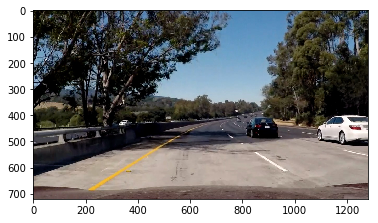

Camera calibrated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Image after undistortion


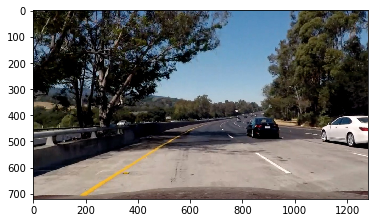

True

In [12]:
### Read a test image and apply distortion correction

image = cv2.imread("test_images\\test5.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print("Image before undistortion")
showImg(image) 

# Calibrate Camera
mtx, dist = calibrate_camera()

# Undistorting using mtx and dist from camera caliberation
image = undistort(image)

print("Image after undistortion")
showImg(image)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
cv2.imwrite('examples/test_undist.jpg',image)

## Validate pipeline on test images

Use test images to validate the pipeline.


Camera calibrated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.79366668e-01  -1.50060593e+00   8.73272564e+02]
 [ -2.77555756e-15  -1.90744658e+00   8.53880078e+02]
 [ -4.66206934e-18  -2.37856879e-03   1.00000000e+00]]
Baseline mid, left, center =  640 398 879
Baeline Lane width in pixels =  481


C:\Users\ADMIN\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel\__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


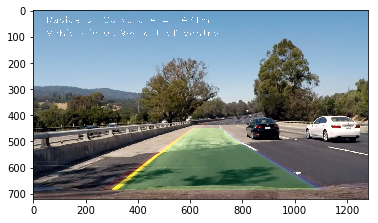

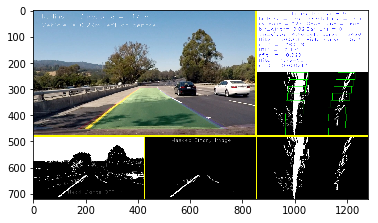

Pair of lanes detected =  1


In [13]:
reset_lanes = True
detected_lines = []

drive_log = open("i_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Calibrate Camera
mtx, dist = calibrate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

image = cv2.imread('test_images/test4.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

marked_img = lane_marker_pipeline(image)
showImg(marked_img)

combined_imgs = img_collage(marked_img)
showImg(combined_imgs)
combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
cv2.imwrite('text_test.jpg',combined_imgs)
#drive_log.close()

"""
images = glob.glob('test_images/test1*')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    marked_img = lane_marker_pipeline(image)
    showImg(marked_img)
    combined_imgs = img_collage(marked_img)
    showImg(combined_imgs)
    combined_imgs = cv2.cvtColor(combined_imgs, cv2.COLOR_RGB2BGR)
    cv2.imwrite('text_test.jpg',combined_imgs)
 
"""

print("Pair of lanes detected = ", len(detected_lines))

## Test lane finding pipeline on Videos

This section reads the clips from the video, passes them to the pipeline and creates a video out of the pipeline outputs



In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Calling pipeline that will return the final output (image where lines are drawn on lanes)
        
    result = lane_marker_pipeline(image)
    result = img_collage(result)

    return result

## Project Video

Applying lane marking pipeline on project video.

In [16]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("p_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'n'

# Calibrate Camera
mtx, dist = calibrate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

project_video_output = 'project_video_output.mp4'
#clip1 = VideoFileClip("P3.mp4")
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output, audio=False)
print("Number of frames = ", len(detected_lines))
drive_log.close()

Camera calibrated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.79366668e-01  -1.50060593e+00   8.73272564e+02]
 [ -2.77555756e-15  -1.90744658e+00   8.53880078e+02]
 [ -4.66206934e-18  -2.37856879e-03   1.00000000e+00]]
Baseline mid, left, center =  640 398 879
Baeline Lane width in pixels =  481
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [04:06<00:00,  5.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 4min 7s
Number of frames =  1261


## Challenge Video

Applying lane marking pipeline on challenge video.

In [17]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("c_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'c'

# Calibrate Camera
mtx, dist = calibrate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

challenge_output = 'challenge_video_output.mp4'
clip2 = VideoFileClip('challenge_video.mp4')
#clip2 = VideoFileClip('c1.mp4')
challenge_video_clip = clip2.fl_image(process_image)
%time challenge_video_clip.write_videofile(challenge_output, audio=False)

drive_log.close()

Camera calibrated.  mtx =  [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]  dist =  [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]
Perspective M =  [[ -3.26733340e-01  -1.35720003e+00   8.52267161e+02]
 [ -2.22044605e-15  -1.85565537e+00   9.23388033e+02]
 [ -2.92734587e-18  -2.15428576e-03   1.00000000e+00]]
Baseline mid, left, center =  640 401 861
Baeline Lane width in pixels =  460
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:33<00:00,  5.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 1min 34s


## Harder Challenge Video

Applying lane marking pipeline on harder video.

In [ ]:
# Initialize variables
reset_lanes = True
detected_lines = []

drive_log = open("h_driveLog.txt","w") 
drive_log.write("Driver's Log -------------------\n")

# use n for normal, c for challenge and h for harder
terrain_type = 'h'

# Calibrate Camera
mtx, dist = calibrate_camera()

# Get perspective
perspective_M, perspective_Minv = compute_perspective()

# Get baseline lane width
baseline_lane_width = compute_lane_width()

harder_challenge_output = 'harder_challenge_video_output.mp4'
clip2 = VideoFileClip('harder_challenge_video.mp4')
#clip2 = VideoFileClip('h3.mp4')
harder_challenge_clip = clip2.fl_image(process_image)
%time harder_challenge_clip.write_videofile(harder_challenge_output, audio=False)

drive_log.close()